In [10]:
#import libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

## Time Series Tasks

1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if needed
     - Use `interpolate()` or `fillna()` for missing values


In [9]:
df = pd.read_csv("patient_longitudinal.csv", sep='\t')
df['visit_date'] = pd.to_datetime(df['visit_date'])

#create series with DatetimeIndex
bp_series = df.set_index('visit_date')['bp_systolic']
bp_series = bp_series[~bp_series.index.duplicated(keep='last')]
bp_series = bp_series.interpolate()

2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

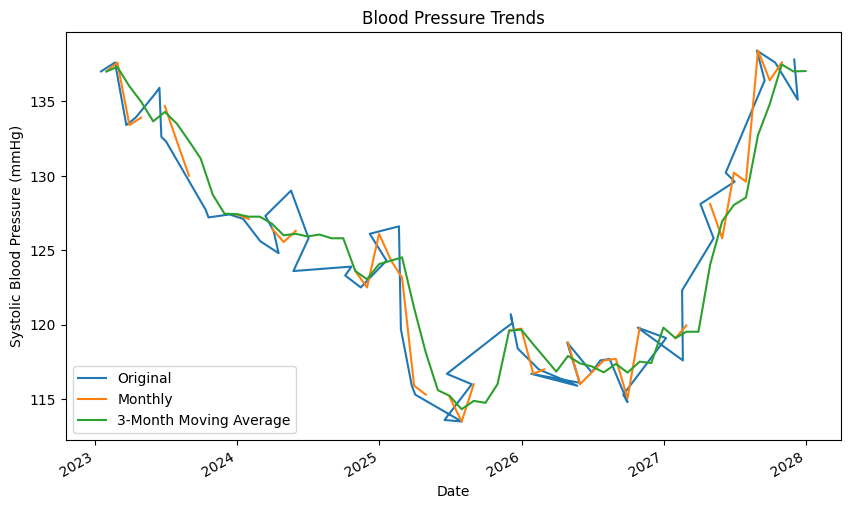

In [15]:
#resample to monthly frequency
bp_monthly = bp_series.resample('ME').mean()

#calculate 3-month moving averages
bp_3ma = bp_monthly.rolling(window=3, min_periods=1).mean()

#visualize trends 
plt.figure(figsize=(10, 6))
bp_series.plot(label='Original')
bp_monthly.plot(label='Monthly')
bp_3ma.plot(label='3-Month Moving Average')
plt.title('Blood Pressure Trends')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend()
plt.show()

## Statistical Modeling Tasks

1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type


In [3]:
df = pd.read_csv('patient_baseline.csv', sep='\t')
X = df[['age', 'bmi', 'smoking', 'diabetes']]
X = sm.add_constant(X)
y= df['bp_systolic']

#fit the OLS model 
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        21:02:00   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

Text(0.5, 1.0, 'Q-Q plot')

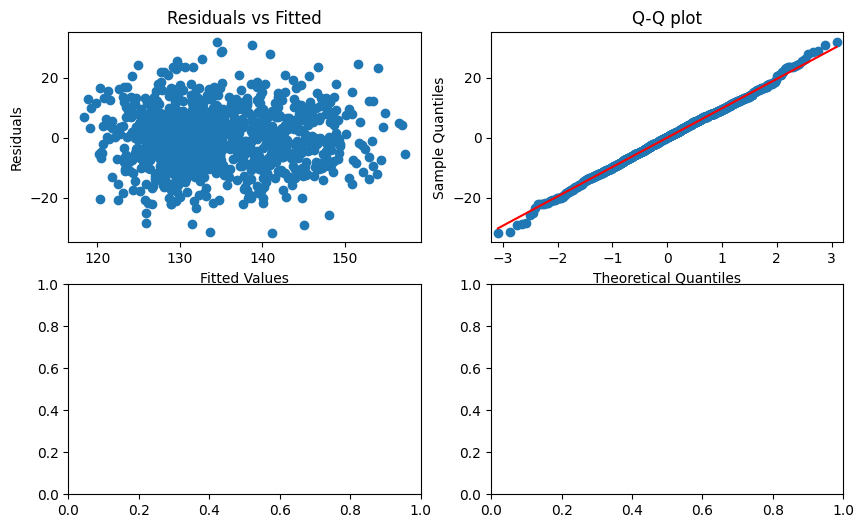

In [9]:
#evaluate model fit and plot 
fig, axes = plt.subplots(2, 2, figsize =(10, 6))

#residuals vs fitted 
axes[0, 0].scatter(model.fittedvalues, model.resid)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')

#Q-Q plot 
sm.graphics.qqplot(model.resid, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q plot')

2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Tue, 05 Nov 2024   Deviance:                       1312.8
Time:                        21:12:59   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

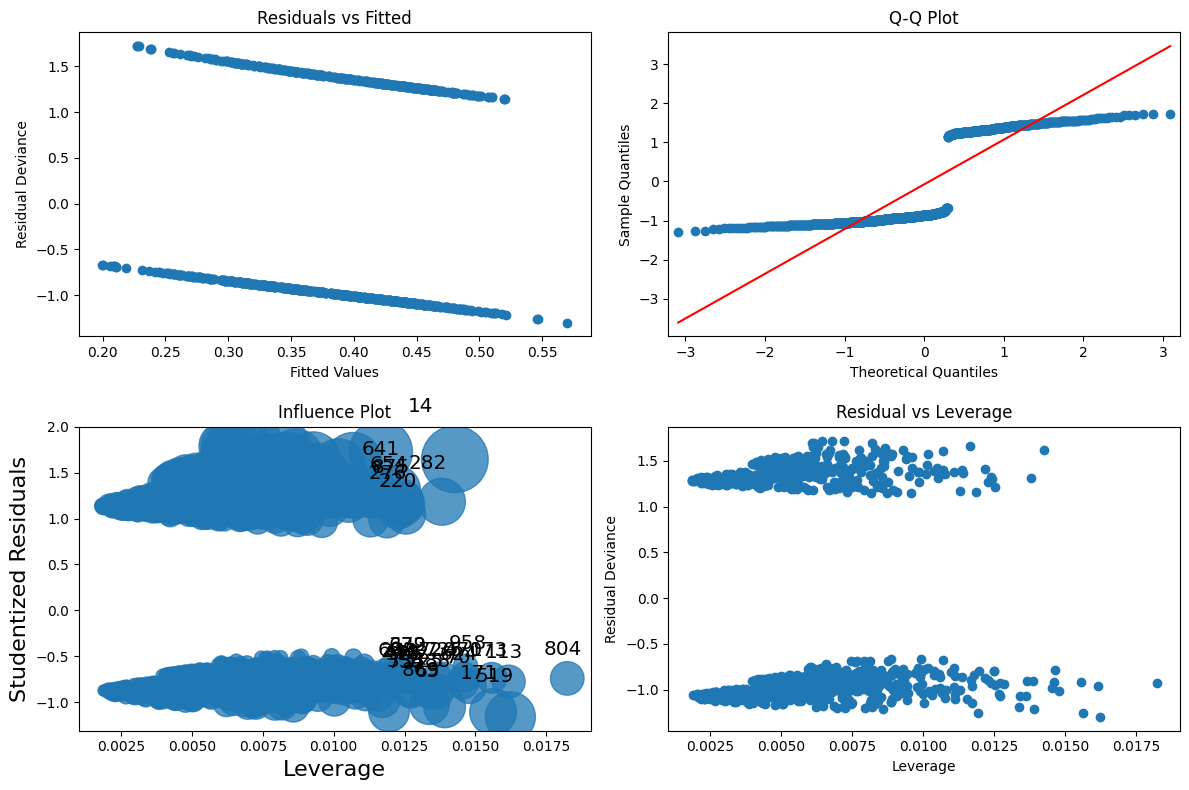

In [13]:
df = pd.read_csv('patient_treatment.csv', sep='\t')
X = df[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
X = sm.add_constant(X)
y = df['outcome']

# fit the binomial GLM model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model.summary())

# odd ratio and 95% CI
params = model.params
conf_int = model.conf_int()
odds_ratios = np.exp(params)
ci_lower = np.exp(conf_int.iloc[:, 0])
ci_upper = np.exp(conf_int.iloc[:, 1])

print("\nOdds Ratios with 95% CI:")
for var, or_, ci_l, ci_u in zip(X.columns, odds_ratios, ci_lower, ci_upper):
    print(f"{var}: {or_:.2f} ({ci_l:.2f}, {ci_u:.2f})")

# diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuals vs Fitted
axes[0, 0].scatter(model.fittedvalues, model.resid_deviance)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residual Deviance')
axes[0, 0].set_title('Residuals vs Fitted')

# Q-Q plot
sm.graphics.qqplot(model.resid_deviance, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')

# influence plot
influence = model.get_influence()
fig = influence.plot_influence(ax=axes[1, 0])
axes[1, 0].set_title('Influence Plot')

# residual vs leverage
leverage = influence.hat_matrix_diag
axes[1, 1].scatter(leverage, model.resid_deviance)
axes[1, 1].set_xlabel('Leverage')
axes[1, 1].set_ylabel('Residual Deviance')
axes[1, 1].set_title('Residual vs Leverage')

plt.tight_layout()
plt.show()